In [19]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [20]:
funding = pd.read_csv(
    r"D:\Homework\QF634\project\TAOUSDT_funding_rate_20200101_20251130.csv",
    parse_dates=["fundingDateTime"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"),
)
funding = funding.sort_values("fundingDateTime")
funding = funding.rename(columns={"fundingDateTime": "timestamp", "fundingRate": "funding_rate"})
funding = funding.drop(columns=["symbol", "formattedFundingDateTime"])
funding.set_index("timestamp", inplace=True)

spot = pd.read_json(
    r"D:\Homework\QF634\project\Data\raw_historical_price\TAOUSDT_5m_binance_spot_historical_data.json",
    lines=True,
).sort_values("timestamp").set_index("timestamp")

future = pd.read_json(
    r"D:\Homework\QF634\project\Data\raw_historical_price\TAOUSDT_5m_binance_futures_historical_data.json",
    lines=True,
).sort_values("timestamp").set_index("timestamp")

spot.index = pd.to_datetime(spot.index)
future.index = pd.to_datetime(future.index)
funding.index = pd.to_datetime(funding.index)

#Remove data from 15 mins before funding rate

fund_times = funding.index.sort_values()

clean_spot_windows = {}
clean_future_windows = {}

for i in range(1, len(fund_times)):
    t_prev = fund_times[i - 1]
    t_curr = fund_times[i]

    window_start = t_prev
    window_end = t_curr - pd.Timedelta(minutes=30)  # remove final 15m

    spot_window = spot.loc[(spot.index >= window_start) & (spot.index < window_end)]
    fut_window = future.loc[(future.index >= window_start) & (future.index < window_end)]

    clean_spot_windows[t_curr] = spot_window
    clean_future_windows[t_curr] = fut_window



C:\Users\timkf\AppData\Local\Temp\ipykernel_20636\1251185448.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  funding = pd.read_csv(


In [21]:
#Feature Engineering

spot_rows = []
future_rows = []

for t in fund_times[1:]:  # skip first because no full window
    sw = clean_spot_windows[t]
    fw = clean_future_windows[t]

    # ---- Spot ----
    spot_rows.append(pd.Series({
        "spot_open": sw["open"].iloc[0] if len(sw) else np.nan,
        "spot_high": sw["high"].max() if len(sw) else np.nan,
        "spot_low": sw["low"].min() if len(sw) else np.nan,
        "spot_close": sw["close"].iloc[-1] if len(sw) else np.nan,
        "spot_volume": sw["volume"].sum() if len(sw) else 0.0,
        "spot_quote_volume": sw["quote_asset_volume"].sum() if len(sw) else 0.0,
        "spot_trades": sw["number_of_trades"].sum() if len(sw) else 0.0,
        "spot_taker_buy_base": sw["taker_buy_base_asset_volume"].sum() if len(sw) else 0.0,
        "spot_taker_buy_quote": sw["taker_buy_quote_asset_volume"].sum() if len(sw) else 0.0,
    }, name=t))

    # ---- Future ----
    future_rows.append(pd.Series({
        "fut_open": fw["open"].iloc[0] if len(fw) else np.nan,
        "fut_high": fw["high"].max() if len(fw) else np.nan,
        "fut_low": fw["low"].min() if len(fw) else np.nan,
        "fut_close": fw["close"].iloc[-1] if len(fw) else np.nan,
        "fut_volume": fw["volume"].sum() if len(fw) else 0.0,
        "fut_quote_volume": fw["quote_asset_volume"].sum() if len(fw) else 0.0,
        "fut_trades": fw["number_of_trades"].sum() if len(fw) else 0.0,
        "fut_taker_buy_base": fw["taker_buy_base_asset_volume"].sum() if len(fw) else 0.0,
        "fut_taker_buy_quote": fw["taker_buy_quote_asset_volume"].sum() if len(fw) else 0.0,
    }, name=t))

spot_8h = pd.DataFrame(spot_rows)
future_8h = pd.DataFrame(future_rows)

# ==========================================================
# 5. MERGE ALL 4H DATA
# ==========================================================
df = funding.merge(spot_8h, left_index=True, right_index=True, how="left") \
            .merge(future_8h, left_index=True, right_index=True, how="left")

# ----------------------------------------------------------
# ASSUME df has: 
# - funding_rate column
# - is_spike column (from classifier labeling)
# - all engineered features used for classifier
# ----------------------------------------------------------

FUNDING_COL = "funding_rate"   # change as needed

df = df.sort_index().copy()
df = df.dropna(subset=[FUNDING_COL])

# ======================================================
# 1. FUNDING LAG FEATURES
# ======================================================
lags = [1, 2, 3, 6, 12]   # 1 lag = 4 hours, 6 = 1 day, 12 = 2 days

for L in lags:
    df[f"funding_lag_{L}"] = df[FUNDING_COL].shift(L)

# ======================================================
# 2. FUNDING ROLLING WINDOWS (4h * N)
# ======================================================
df["funding_vol_3"] = df[FUNDING_COL].rolling(3, closed='left').std()
df["funding_vol_6"] = df[FUNDING_COL].rolling(6,closed='left').std()
df["funding_vol_12"] = df[FUNDING_COL].rolling(12, closed='left').std()

def rolling_max_drawdown_safe(series, window):
    s = series.shift(1)  # exclude current
    roll = s.rolling(window)
    return (roll.max() - s) / roll.max()

df["funding_mdd_6"]  = rolling_max_drawdown_safe(df[FUNDING_COL], 6)
df["funding_mdd_12"] = rolling_max_drawdown_safe(df[FUNDING_COL], 12)

# ======================================================
# 3. BASIS FEATURES (future - spot)
# ======================================================
df["basis"] = df["fut_close"] - df["spot_close"]
df["basis_change"] = df["basis"] - df["basis"].shift(1)
df["basis_lag_1"] = df["basis"].shift(1)
df["basis_lag_3"] = df["basis"].shift(3)

# ======================================================
# 4. PRICE MOMENTUM (spot + future)
# ======================================================
for c in ["spot_close", "fut_close"]:
    df[f"{c}_ret_1"] = df[c].pct_change(1)
    df[f"{c}_ret_3"] = df[c].pct_change(3)
    df[f"{c}_ret_6"] = df[c].pct_change(6)

# ======================================================
# 5. PRICE VOLATILITY (spot + future)
# ======================================================
for c in ["spot_close", "fut_close"]:
    df[f"{c}_vol_3"] = df[c].pct_change().rolling(3).std()
    df[f"{c}_vol_6"] = df[c].pct_change().rolling(6).std()

# ======================================================
# 6. VOLUME PRESSURE FEATURES
# ======================================================
df["spot_buy_ratio"] = df["spot_taker_buy_base"] / (df["spot_volume"] + 1e-9)
df["fut_buy_ratio"]  = df["fut_taker_buy_base"] / (df["fut_volume"] + 1e-9)

df["spot_buy_ratio_lag1"] = df["spot_buy_ratio"].shift(1)
df["fut_buy_ratio_lag1"]  = df["fut_buy_ratio"].shift(1)

# ======================================================
# REMOVE ROWS WITH NAN FROM LAGS
# ======================================================
df_prepared_features = df.dropna()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3585 entries, 2024-04-11 16:00:00 to 2025-11-30 00:00:00.003000
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   funding_rate          3585 non-null   float64
 1   markPrice             3585 non-null   float64
 2   spot_open             3584 non-null   float64
 3   spot_high             3584 non-null   float64
 4   spot_low              3584 non-null   float64
 5   spot_close            3584 non-null   float64
 6   spot_volume           3584 non-null   float64
 7   spot_quote_volume     3584 non-null   float64
 8   spot_trades           3584 non-null   float64
 9   spot_taker_buy_base   3584 non-null   float64
 10  spot_taker_buy_quote  3584 non-null   float64
 11  fut_open              3584 non-null   float64
 12  fut_high              3584 non-null   float64
 13  fut_low               3584 non-null   float64
 14  fut_close             3584 no

In [23]:
df.corr()

,funding_rate,markPrice,spot_open,spot_high,spot_low,spot_close,spot_volume,spot_quote_volume,spot_trades,spot_taker_buy_base,...,fut_close_ret_3,fut_close_ret_6,spot_close_vol_3,spot_close_vol_6,fut_close_vol_3,fut_close_vol_6,spot_buy_ratio,fut_buy_ratio,spot_buy_ratio_lag1,fut_buy_ratio_lag1
funding_rate,1.000000,0.336668,0.338833,0.331972,0.348477,0.335209,-0.181020,-0.025134,-0.117752,-0.181345,...,0.004185,0.024759,-0.079468,-0.100847,-0.079305,-0.100205,-0.012017,-0.065174,0.052144,-0.020718
markPrice,0.336668,1.000000,0.994902,0.997550,0.995998,0.999439,0.126015,0.396286,0.211139,0.139727,...,0.073638,0.104341,0.079131,0.097153,0.079443,0.097755,0.116973,-0.006343,0.118560,-0.005860
spot_open,0.338833,0.994902,1.000000,0.997232,0.995715,0.995422,0.125086,0.393728,0.212156,0.133225,...,0.026130,0.069691,0.070624,0.089733,0.070959,0.090381,0.079617,-0.045618,0.117051,-0.005828
spot_high,0.331972,0.997550,0.997232,1.000000,0.994680,0.998025,0.152147,0.420708,0.236709,0.163680,...,0.055680,0.091024,0.096255,0.114949,0.096600,0.115541,0.103483,-0.022140,0.119066,-0.003859
spot_low,0.348477,0.995998,0.995715,0.994680,1.000000,0.996468,0.082112,0.354188,0.167719,0.093991,...,0.056963,0.092646,0.048054,0.067881,0.048296,0.068515,0.099972,-0.019894,0.116315,-0.004577
spot_close,0.335209,0.999439,0.995422,0.998025,0.996468,1.000000,0.124970,0.395538,0.210167,0.138795,...,0.074394,0.103893,0.078896,0.097171,0.079212,0.097778,0.117508,-0.005624,0.117730,-0.005778
spot_volume,-0.181020,0.126015,0.125086,0.152147,0.082112,0.124970,1.000000,0.931382,0.923267,0.992753,...,0.014735,0.017153,0.447046,0.470355,0.447948,0.470619,0.045637,-0.013344,0.049701,-0.000360
spot_quote_volume,-0.025134,0.396286,0.393728,0.420708,0.354188,0.395538,0.931382,1.000000,0.898424,0.930088,...,0.061465,0.076082,0.416180,0.437958,0.417063,0.438384,0.073159,-0.013606,0.080292,0.001255
spot_trades,-0.117752,0.211139,0.212156,0.236709,0.167719,0.210167,0.923267,0.898424,1.000000,0.917997,...,0.021844,0.021703,0.440252,0.480605,0.441351,0.481121,0.047239,-0.016199,0.054351,0.001855
spot_taker_buy_base,-0.181345,0.139727,0.133225,0.163680,0.093991,0.138795,0.992753,0.930088,0.917997,1.000000,...,0.052422,0.047719,0.447425,0.471350,0.448252,0.471564,0.134540,0.029711,0.058204,0.001120


In [91]:
from lightgbm import LGBMRegressor

features = [c for c in df.columns 
            if c not in ["timestamp","markPrice", FUNDING_COL]]

df = df.sort_values("timestamp")

# Determine split index
split_ratio = 0.7
split_index = int(len(df) * split_ratio)

# Time-based train-test split
train = df.iloc[:split_index]
test  = df.iloc[split_index:]

X_train = train[features]
y_train = train[FUNDING_COL]

X_test = test[features]
y_test = test[FUNDING_COL]

print(features)


['spot_open', 'spot_high', 'spot_low', 'spot_close', 'spot_volume', 'spot_quote_volume', 'spot_trades', 'spot_taker_buy_base', 'spot_taker_buy_quote', 'fut_open', 'fut_high', 'fut_low', 'fut_close', 'fut_volume', 'fut_quote_volume', 'fut_trades', 'fut_taker_buy_base', 'fut_taker_buy_quote', 'funding_lag_1', 'funding_lag_2', 'funding_lag_3', 'funding_lag_6', 'funding_lag_12', 'funding_vol_3', 'funding_vol_6', 'funding_vol_12', 'funding_mdd_6', 'funding_mdd_12', 'basis', 'basis_change', 'basis_lag_1', 'basis_lag_3', 'spot_close_ret_1', 'spot_close_ret_3', 'spot_close_ret_6', 'fut_close_ret_1', 'fut_close_ret_3', 'fut_close_ret_6', 'spot_close_vol_3', 'spot_close_vol_6', 'fut_close_vol_3', 'fut_close_vol_6', 'spot_buy_ratio', 'fut_buy_ratio', 'spot_buy_ratio_lag1', 'fut_buy_ratio_lag1']


In [25]:
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.02,
    num_leaves=64,
    subsample=0.9,
    colsample_bytree=0.9
)

model.fit(X_train, y_train)

# -------------------------
# 7. Predict
# -------------------------
preds = model.predict(X_test)

# -------------------------
# 8. Evaluate
# -------------------------
mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)

print("Latest predicted 48h cumulative funding:", preds[-1])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11712
[LightGBM] [Info] Number of data points in the train set: 2509, number of used features: 46
[LightGBM] [Info] Start training from score 0.000032
MAE: 3.1432000179209735e-05
Latest predicted 48h cumulative funding: 1.788362741616471e-05


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3585 entries, 2024-04-11 16:00:00 to 2025-11-30 00:00:00.003000
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   funding_rate          3585 non-null   float64
 1   markPrice             3585 non-null   float64
 2   spot_open             3584 non-null   float64
 3   spot_high             3584 non-null   float64
 4   spot_low              3584 non-null   float64
 5   spot_close            3584 non-null   float64
 6   spot_volume           3584 non-null   float64
 7   spot_quote_volume     3584 non-null   float64
 8   spot_trades           3584 non-null   float64
 9   spot_taker_buy_base   3584 non-null   float64
 10  spot_taker_buy_quote  3584 non-null   float64
 11  fut_open              3584 non-null   float64
 12  fut_high              3584 non-null   float64
 13  fut_low               3584 non-null   float64
 14  fut_close             3584 no

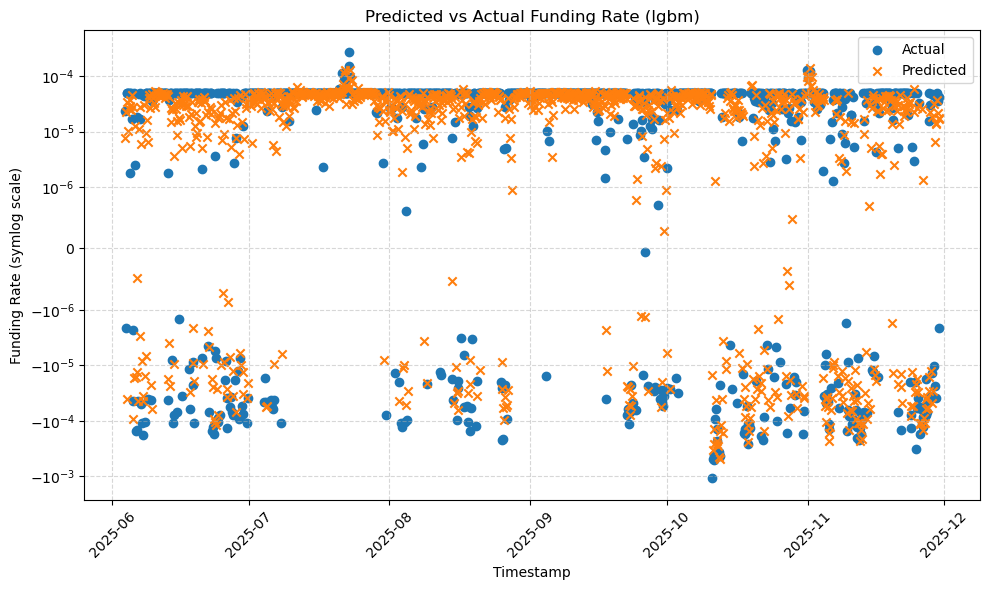

In [28]:
import matplotlib.pyplot as plt

# Extract corresponding timestamps for test set
#test_timestamps = df.iloc[len(df) - len(y_test):]["timestamp"]

plt.figure(figsize=(10,6))
plt.scatter(y_test.index, y_test, label="Actual", marker='o')
plt.scatter(y_test.index, preds, label="Predicted", marker='x')

# plt.plot(y_test.index, y_test, label="Actual", marker='o')
# plt.plot(y_test.index, preds, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Funding Rate (lgbm)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.02,
    depth=6,                 # ~ log2(64 leaves)
    subsample=0.9,
    rsm=0.9,                 # feature subsample (colsample_bytree)
    loss_function="MAE",
    random_seed=42,
    verbose=False
)

model.fit(X_train, y_train)

# -------------------------
# 7. Predict
# -------------------------
preds = model.predict(X_test)

# -------------------------
# 8. Evaluate
# -------------------------
mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)

print("Latest predicted 48h cumulative funding:", preds[-1])



MAE: 2.6283521211164623e-05
Latest predicted 48h cumulative funding: 4.6068123279451846e-05


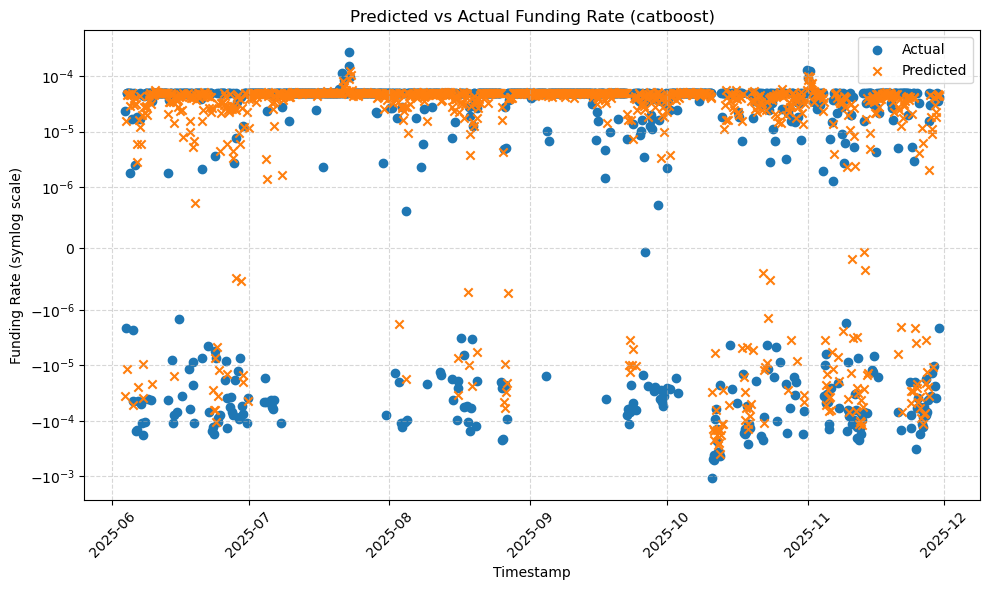

In [30]:
import matplotlib.pyplot as plt

# Extract corresponding timestamps for test set
#test_timestamps = df.iloc[len(df) - len(y_test):]["timestamp"]

plt.figure(figsize=(10,6))
plt.scatter(y_test.index, y_test, label="Actual", marker='o')
plt.scatter(y_test.index, preds, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Funding Rate (catboost)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
RNN_FEATURES = [
    # Spot OHLCV
    "spot_open", "spot_high", "spot_low", "spot_close",
    "spot_volume", "spot_quote_volume", "spot_trades",
    "spot_taker_buy_base", "spot_taker_buy_quote",

    # Futures OHLCV
    "fut_open", "fut_high", "fut_low", "fut_close",
    "fut_volume", "fut_quote_volume", "fut_trades",
    "fut_taker_buy_base", "fut_taker_buy_quote",

    # Basis & order flow
    "basis",
    "spot_buy_ratio", "fut_buy_ratio",

    # Short-term returns
    "spot_close_ret_1",
    "fut_close_ret_1",
]

In [32]:
print(X_train.shape)
print(y_train.shape)

(2509, 46)
(2509,)


In [33]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df_model = df[RNN_FEATURES + [FUNDING_COL]].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[RNN_FEATURES])
y = df_model[FUNDING_COL].values

In [34]:
LOOKBACK = 12   # number of past timesteps

def make_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = make_sequences(X_scaled, y, LOOKBACK)

index_seq = df_model.index[LOOKBACK:]

In [35]:
split = int(len(X_seq) * 0.7)

X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

index_train = index_seq[:split]
index_test  = index_seq[split:]

In [36]:
model = Sequential([
    SimpleRNN(64, activation="tanh", input_shape=(LOOKBACK, X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/100


c:\Users\timkf\anaconda3\envs\QF634_project\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2862 - mae: 0.4140 - val_loss: 0.0483 - val_mae: 0.1715
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1451 - mae: 0.3010 - val_loss: 0.0242 - val_mae: 0.1218
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1118 - mae: 0.2625 - val_loss: 0.0174 - val_mae: 0.1007
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0773 - mae: 0.2193 - val_loss: 0.0092 - val_mae: 0.0728
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0570 - mae: 0.1864 - val_loss: 0.0067 - val_mae: 0.0650
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0400 - mae: 0.1557 - val_loss: 0.0046 - val_mae: 0.0516
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339 - mae: 0.1446 - val_loss: 0.0039 - val_mae: 0.0487
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - mae: 0.1290 - val_loss: 0.0030 - val_mae: 0.0429
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - mae: 0.1

In [37]:
y_pred = model.predict(X_test).flatten()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [38]:
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0017e-09 - mae: 5.6846e-05 
Test loss: [6.001671160049682e-09, 5.6846471125027165e-05]


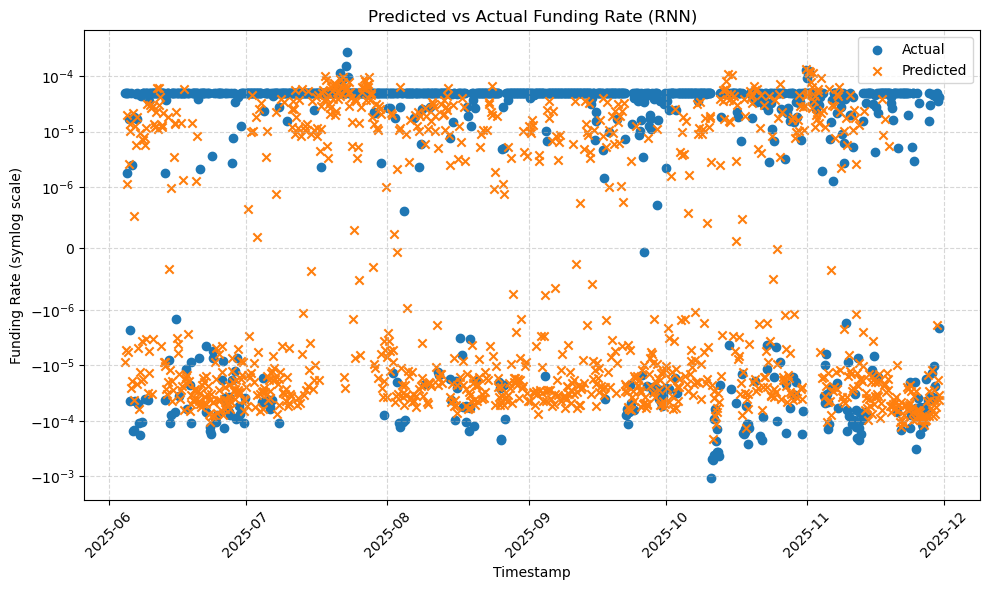

In [39]:
plt.figure(figsize=(10,6))
plt.scatter(index_test, y_test, label="Actual", marker='o')
plt.scatter(index_test, y_pred, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Funding Rate (RNN)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(
        128,
        activation="tanh",
        input_shape=(LOOKBACK, X_train.shape[2])
    ),
    Dropout(0.3),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0224 - mae: 0.1103 - val_loss: 5.3557e-04 - val_mae: 0.0192
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - mae: 0.0654 - val_loss: 9.0180e-05 - val_mae: 0.0075
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0459 - val_loss: 1.1886e-04 - val_mae: 0.0088
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - mae: 0.0379 - val_loss: 1.1973e-04 - val_mae: 0.0094
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - mae: 0.0316 - val_loss: 1.9966e-04 - val_mae: 0.0116
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 6.0311e-05 - val_mae: 0.0059
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3072e-04 - mae: 0.0233 - val_loss: 1.2057e-04 - val_mae: 0.0091
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0294e-04 - mae: 0.0216 - val_loss: 5.3466e-05 - val_mae: 0.0061
Epoch 9/100
71/71 ━━━━━━

In [41]:
y_pred = model.predict(X_test).flatten()
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8765e-06 - mae: 0.0010    
Test loss: [1.8765157392408582e-06, 0.0010466036619618535]


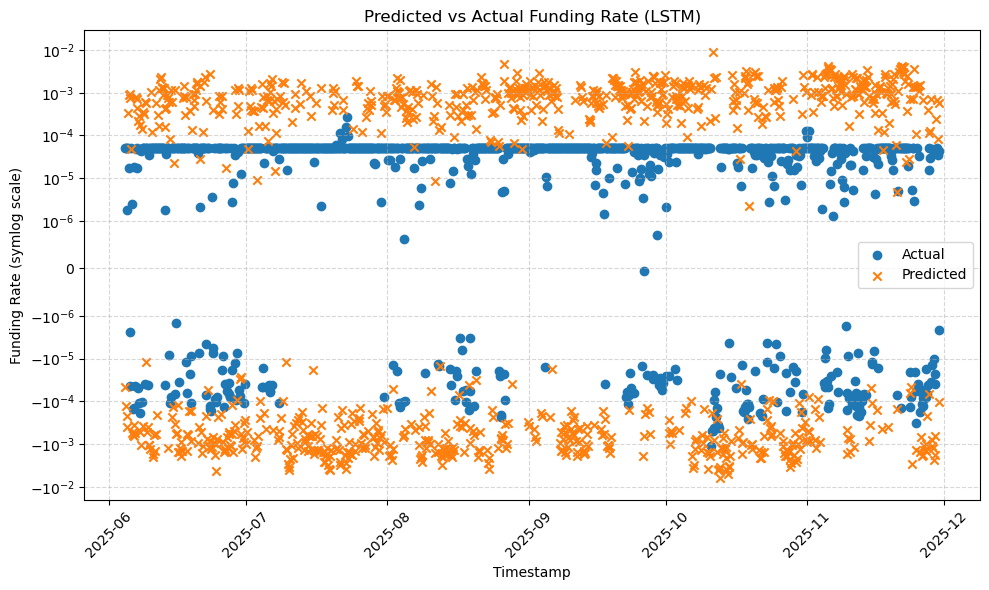

In [43]:
plt.figure(figsize=(10,6))
plt.scatter(index_test, y_test, label="Actual", marker='o')
plt.scatter(index_test, y_pred, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Funding Rate (LSTM)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Layer
)
from tensorflow.keras.callbacks import EarlyStopping



class TemporalAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True
        )
        super().build(input_shape)

    def call(self, x):
        # x: (batch, time, features)
        e = tf.tensordot(x, self.W, axes=1) + self.b  # (batch, time, 1)
        a = tf.nn.softmax(e, axis=1)                  # attention weights
        out = tf.reduce_sum(x * a, axis=1)            # context vector
        return out
    
def build_rnn_attention_model(lookback, n_features):
    inputs = Input(shape=(lookback, n_features))
    x = SimpleRNN(
    128,
    return_sequences=True,
    dropout=0.2
    )(inputs)

    x = Dropout(0.2)(x)

    x = TemporalAttention()(x)

    x = Dense(64, activation="relu")(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    return model

In [49]:
model = build_rnn_attention_model(LOOKBACK, X_train.shape[2])

model.compile(
    optimizer=tf.keras.optimizers.Adam(clipnorm=1.0),
    loss=tf.keras.losses.Huber(delta=1e-4),
    metrics=["mae"]
)

es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=150,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.4907e-05 - mae: 0.1491 - val_loss: 5.1876e-06 - val_mae: 0.0519
Epoch 2/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4722e-06 - mae: 0.0948 - val_loss: 5.5409e-06 - val_mae: 0.0555
Epoch 3/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1963e-06 - mae: 0.0720 - val_loss: 2.9962e-06 - val_mae: 0.0300
Epoch 4/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1897e-06 - mae: 0.0619 - val_loss: 3.2885e-06 - val_mae: 0.0329
Epoch 5/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1774e-06 - mae: 0.0518 - val_loss: 2.7906e-06 - val_mae: 0.0280
Epoch 6/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6208e-06 - mae: 0.0463 - val_loss: 1.9395e-06 - val_mae: 0.0194
Epoch 7/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8223e-06 - mae: 0.0383 - val_loss: 1.8935e-06 - val_mae: 0.0190
Epoch 8/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7336e-06 - mae: 0.0374 - val_loss: 1.3322e-06 - val_mae: 0.0134


In [50]:
y_pred = model.predict(X_test).flatten()
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5945e-08 - mae: 3.0512e-04 
Test loss: [2.5945126935766893e-08, 0.0003051228995900601]


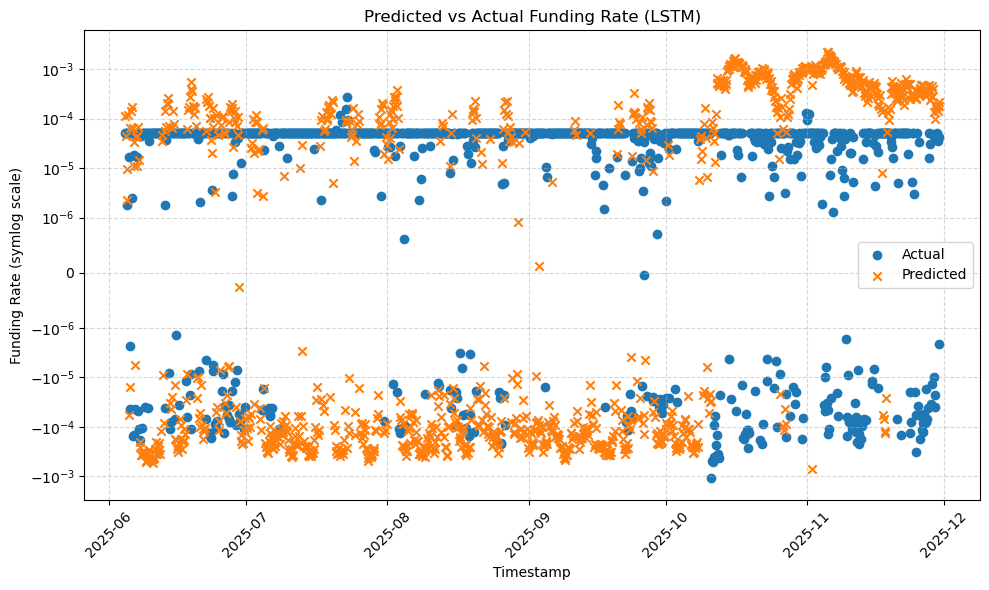

In [51]:
plt.figure(figsize=(10,6))
plt.scatter(index_test, y_test, label="Actual", marker='o')
plt.scatter(index_test, y_pred, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Funding Rate (LSTM)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
df["funding_rate"].describe()

count    3585.000000
mean        0.000029
std         0.000090
min        -0.001098
25%         0.000040
50%         0.000050
75%         0.000050
max         0.000456
Name: funding_rate, dtype: float64

In [67]:
class WeightedSpike(tf.keras.losses.Loss):
    def __init__(
        self,
        spike_threshold=0.0002,
        spike_weight=5.0,
        name="weighted_spike_mae"
    ):
        super().__init__(name=name)
        self.spike_threshold = spike_threshold
        self.spike_weight = spike_weight

    def call(self, y_true, y_pred):
        error = tf.square(y_true - y_pred) #On MSE, to folow previous experiment
        # error = tf.abs(y_true - y_pred) #On MSE, to folow previous experiment

        # Spike mask based on true value
        spike_mask = tf.cast(
            tf.abs(y_true) >= self.spike_threshold,
            tf.float32
        )

        weights = 1.0 + spike_mask * (self.spike_weight - 1.0)

        return tf.reduce_mean(weights * error)

model = Sequential([
    SimpleRNN(64, activation="tanh", input_shape=(LOOKBACK, X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

# model.compile(
#     optimizer="adam",
#     loss=WeightedSpike(
#         spike_threshold=0.0002,   # define spike
#         spike_weight=2.5          # spike importance
#     ),
#     metrics=["mae"]
# )

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.Huber(delta=0.01),  # <-- Huber loss
    metrics=["mae"]
)

es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0045 - mae: 0.4547 - val_loss: 0.0016 - val_mae: 0.1643
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - mae: 0.3276 - val_loss: 0.0013 - val_mae: 0.1399
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - mae: 0.2646 - val_loss: 9.5223e-04 - val_mae: 0.1001
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - mae: 0.2165 - val_loss: 6.9226e-04 - val_mae: 0.0741
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - mae: 0.1770 - val_loss: 6.0278e-04 - val_mae: 0.0651
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mae: 0.1489 - val_loss: 4.4782e-04 - val_mae: 0.0496
Epoch 7/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mae: 0.1203 - val_loss: 3.6381e-04 - val_mae: 0.0412
Epoch 8/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0144e-04 - mae: 0.0950 - val_loss: 2.6369e-04 - val_mae: 0.0310
Epoch 9/200
71/71 ━━━━━━━━━━━━━━━━━━

In [68]:
y_pred = model.predict(X_test).flatten()
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 2.9990e-09 - mae: 5.6748e-05
Test loss: [2.9990421257508615e-09, 5.674792919307947e-05]


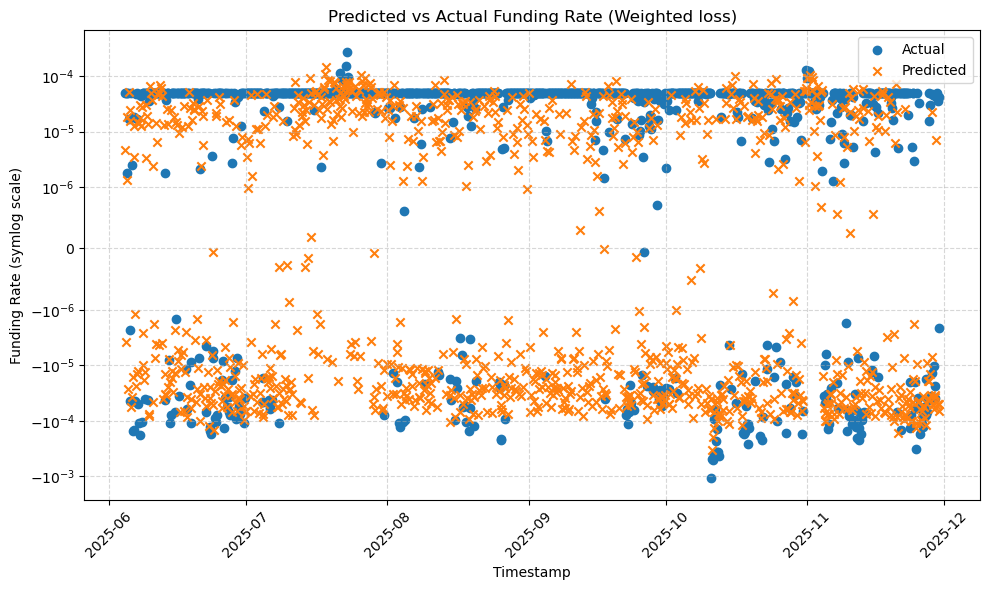

In [69]:
plt.figure(figsize=(10,6))
plt.scatter(index_test, y_test, label="Actual", marker='o')
plt.scatter(index_test, y_pred, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Funding Rate (Weighted loss)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [88]:
model.compile(
    optimizer="adam",
    loss=WeightedSpike(
        spike_threshold=0.001,   # define spike
        spike_weight=2.5          # spike importance
    ),
    metrics=["mae"]
)

es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0958e-06 - mae: 6.9573e-04 - val_loss: 5.7821e-08 - val_mae: 1.8604e-04
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6105e-08 - mae: 1.7886e-04 - val_loss: 2.6454e-08 - val_mae: 1.0432e-04
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1708e-07 - mae: 2.1592e-04 - val_loss: 2.4001e-08 - val_mae: 1.0895e-04
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9974e-08 - mae: 1.5823e-04 - val_loss: 1.1875e-07 - val_mae: 3.0320e-04
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6681e-07 - mae: 3.5417e-04 - val_loss: 4.4987e-08 - val_mae: 1.5495e-04
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4503e-07 - mae: 2.6969e-04 - val_loss: 4.4670e-08 - val_mae: 1.6146e-04
Epoch 7/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5800e-08 - mae: 1.6800e-04 - val_loss: 2.8266e-08 - val_mae: 1.1539e-04
Epoch 8/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6731e-08

In [89]:
y_pred = model.predict(X_test).flatten()
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5425e-09 - mae: 5.6620e-05 
Test loss: [7.542499957935433e-09, 5.662021430907771e-05]


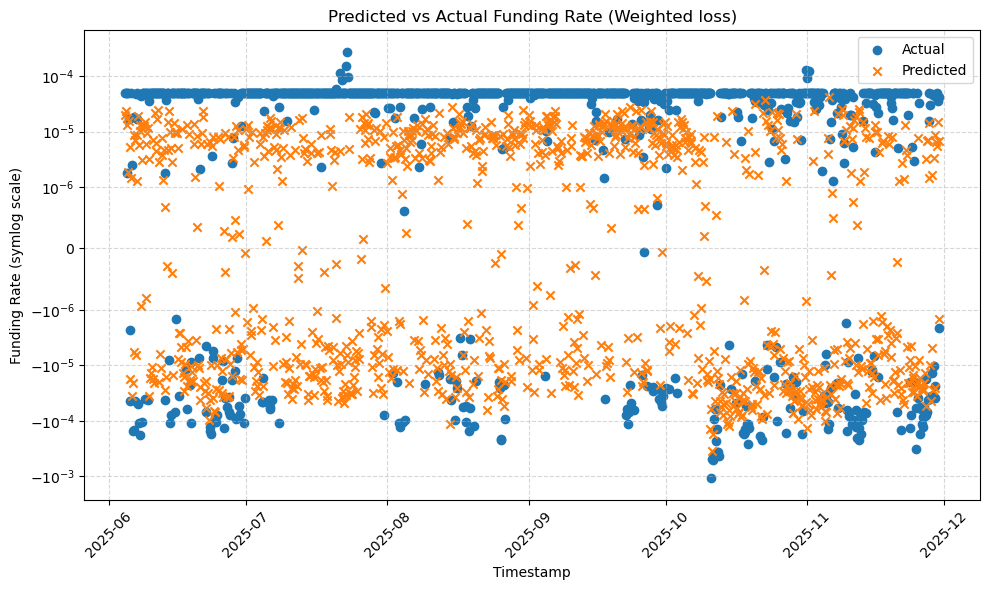

In [90]:
plt.figure(figsize=(10,6))
plt.scatter(index_test, y_test, label="Actual", marker='o')
plt.scatter(index_test, y_pred, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Funding Rate (Weighted loss)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
model = LGBMRegressor(
    objective="huber",
    alpha=0.9,          # controls robustness / transition point (tune this)
    n_estimators=500,
    learning_rate=0.02,
    num_leaves=64,
    subsample=0.9,
    colsample_bytree=0.9
)

model.fit(X_train, y_train)

# -------------------------
# 7. Predict
# -------------------------
preds = model.predict(X_test)

# -------------------------
# 8. Evaluate
# -------------------------
mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)

print("Latest predicted 48h cumulative funding:", preds[-1])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11712
[LightGBM] [Info] Number of data points in the train set: 2509, number of used features: 46
[LightGBM] [Info] Start training from score 0.000032
MAE: 3.1432000179209735e-05
Latest predicted 48h cumulative funding: 1.788362741616471e-05


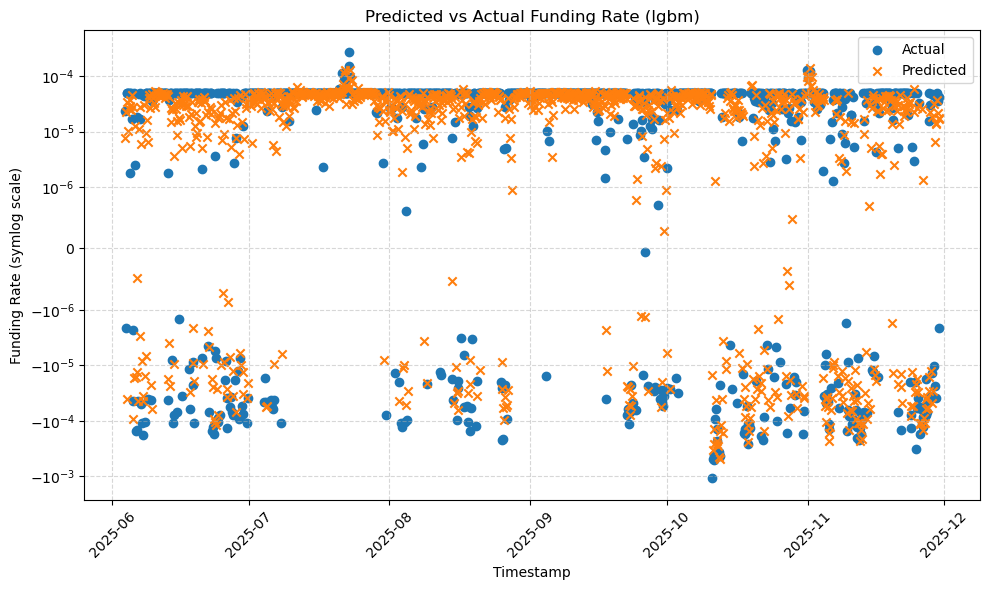

In [93]:
import matplotlib.pyplot as plt

# Extract corresponding timestamps for test set
#test_timestamps = df.iloc[len(df) - len(y_test):]["timestamp"]

plt.figure(figsize=(10,6))
plt.scatter(y_test.index, y_test, label="Actual", marker='o')
plt.scatter(y_test.index, preds, label="Predicted", marker='x')

# plt.plot(y_test.index, y_test, label="Actual", marker='o')
# plt.plot(y_test.index, preds, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Funding Rate (lgbm)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    loss_function="Huber:delta=0.01",  # delta ≈ robustness threshold
    iterations=500,
    learning_rate=0.02,
    depth=6,              # roughly comparable to num_leaves=64
    subsample=0.9,
    rsm=0.9,              # feature subsampling (colsample_bytree)
    random_seed=42,
    verbose=False
)

model.fit(X_train, y_train)

# -------------------------
# 7. Predict
# -------------------------
preds = model.predict(X_test)

# -------------------------
# 8. Evaluate
# -------------------------
mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)

print("Latest predicted 48h cumulative funding:", preds[-1])